# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
from gpt import gpt

### Download dataset from here:  
https://s3-us-west-2.amazonaws.com/ashaw-music/v6/v6.tar.gz

In [4]:
path = Path('data/midi/v7/midi_encode/text/shortdur/')
get_files(path/'models/fastai/txl', recurse=True)

[PosixPath('data/midi/v7/midi_encode/text/shortdur/models/fastai/txl/pop/1_ep30_run1_best.pth'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/models/fastai/txl/pop/1_ep30_run1.pth'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/models/fastai/txl/clc/1_ep60_run1_best.pth'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/models/fastai/txl/clc/1_ep60_run1.pth'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/models/fastai/txl/hook/1_ep80_run1_best.pth'),
 PosixPath('data/midi/v7/midi_encode/text/shortdur/models/fastai/txl/hook/1_ep80_run1.pth')]

## Download pretrained model from here:
https://s3-us-west-2.amazonaws.com/ashaw-music/v6/shortdur/models/fastai/txl/hook/4_ep20_run2_bptt256_mem1024_full.pth

In [5]:
model_path = 'fastai/txl/hook/1_ep80_run1_best'

In [6]:
bs=8
bptt=500

In [7]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t',
 array([ 2,  9,  8, 21, ..., 40, 26, 36, 26]))

In [8]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

266

In [41]:
# set([k[:-1] for k in vocab.stoi.keys() if k[0] == 'n'])

In [9]:
data.train_dl.dl.dataset.idx.shuffle()

In [10]:
data.train_dl.dl.dataset.shuffle

True

In [11]:
data.train_dl.dl.dataset.idx.idx

array([ 1135,  1590,  5747,  4336, ..., 13784,  6279,  8920, 12061])

### Load Learner

In [12]:
cuda_enabled = torch.cuda.is_available()

In [13]:
tfmerXL_lm_config['ctx_len'] = 512
tfmerXL_lm_config['mem_len'] = 1024

In [14]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:213: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [15]:
learn = learn.load(model_path, strict=False)

## Done

In [16]:
# learn.show_results(rows=5, max_len=25)

In [160]:
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)

file = np.random.choice(files); file

PosixPath('data/midi/v7/midi_encode/text/shortdur/hooktheory/pianoroll/b/britney-spears/toxic/chorus_key.txt')

In [161]:
# Loading from specific file
# edm_f = [f for f in files if 'avicii/waiting' in str(f)]; edm_f
# file = edm_f[1]

### Create seed sequence

In [162]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(288,
 '|| t12 nG4 t2 || t1 nB-4 t2 || t1 nC3 t6 nE-3 t6 nG3 t6 nD5 t4 || t3 nC5 t2 || t1 nC3 t10 nE-3 t10 nG3 t10 nB-4 t2 || t1 nB-4 t4 || t3 nG4 t4 || t3 nE-3 t6 nG3 t6 nB-3 t6 nC#4 t6 nF4 t2 || t1 nE-4 t2 || t1 nB-4 t8 || t1 nE-3 t10 nG3 t10 nB-3 t10 nC#4 t10 || t9 nD3 t6 nF#3 t6 nA3 t6 nC4 t6')

In [163]:
ns = str2stream(seed)
ns.show('midi')

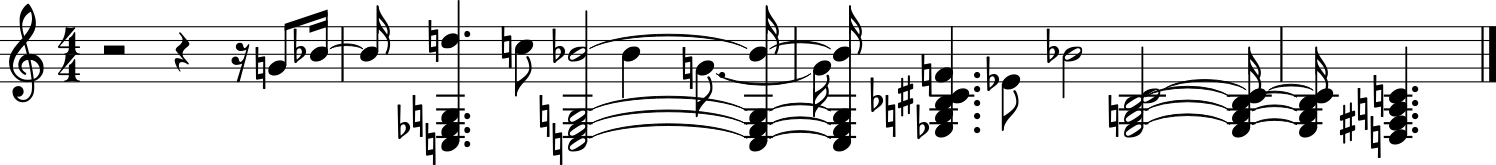

In [164]:
ns = str2stream(seed).show()

### Full song

In [165]:
# full song
str2stream(' '.join(notes)).show('midi')

### Predictions without beam search

In [166]:
pred_out = learn.predict(seed, n_words=300, temperature=1.5, min_p=0.05); pred_out

'|| t12 nG4 t2 || t1 nB-4 t2 || t1 nC3 t6 nE-3 t6 nG3 t6 nD5 t4 || t3 nC5 t2 || t1 nC3 t10 nE-3 t10 nG3 t10 nB-4 t2 || t1 nB-4 t4 || t3 nG4 t4 || t3 nE-3 t6 nG3 t6 nB-3 t6 nC#4 t6 nF4 t2 || t1 nE-4 t2 || t1 nB-4 t8 || t1 nE-3 t10 nG3 t10 nB-3 t10 nC#4 t10 || t9 nD3 t6 nF#3 t6 nA3 t6 nC4 t6 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nD3 t10 nF#3 t10 nA3 t10 nC4 t10 nB-4 t2 || t1 nB-4 t4 || t3 nG4 t2 || t1 nF4 t2 || t1 nF3 t6 nG#3 t6 nC4 t6 nE-4 t2 nE-4 t6 || t1 nG4 t2 || t1 nG4 t6 || t1 nF3 t10 nG#3 t10 nC4 t10 nE-4 t10 || t9 nB-2 t6 nD3 t6 nF3 t6 nG#3 t6 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t4 || t1 nB-2 t10 nD3 t10 nF3 t10 nG#3 t10 || t1 nB-4 t4 || t3 nC5 t2 || t1 nG4 t10 || t1 nE-3 t6 nG3 t6 nB-3 t6 nC#4 t6 || t5 nE-3 t10 nG3 t10 nB-3 t10 nC#4 t10 || t3 nG4 t2 || t1 nG4 t2 || t1 nF4 t2 || t1 nC3 t6 nE-3 t6 nG3 t6 nE-5 t4 || t3 nD5 t2 || t1 nC3 t10 nE-3 t10 nG3 t10 nC5 t2 || t1 nC5 t4 || t3 nG4 t4 || t3 nE-3 t6 nG3 t6 nB-3 t6 nC#4 t6 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t8 || t1 nE-3 t10 nG3 t10 nB-3 

In [167]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t1 nB-4 t2 || t1 nB-4 t2 || t1 nD3 t10 nF#3 t10 nA3 t10 nC4 t10 nB-4 t2 || t1 nB-4 t4 || t3 nG4 t2 || t1 nF4 t2 || t1 nF3 t6 nG#3 t6 nC4 t6 nE-4 t2 nE-4 t6 || t1 nG4 t2 || t1 nG4 t6 || t1 nF3 t10 nG#3 t10 nC4 t10 nE-4 t10 || t9 nB-2 t6 nD3 t6 nF3 t6 nG#3 t6 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t4 || t1 nB-2 t10 nD3 t10 nF3 t10 nG#3 t10 || t1 nB-4 t4 || t3 nC5 t2 || t1 nG4 t10 || t1 nE-3 t6 nG3 t6 nB-3 t6 nC#4 t6 || t5 nE-3 t10 nG3 t10 nB-3 t10 nC#4 t10 || t3 nG4 t2 || t1 nG4 t2 || t1 nF4 t2 || t1 nC3 t6 nE-3 t6 nG3 t6 nE-5 t4 || t3 nD5 t2 || t1 nC3 t10 nE-3 t10 nG3 t10 nC5 t2 || t1 nC5 t4 || t3 nG4 t4 || t3 nE-3 t6 nG3 t6 nB-3 t6 nC#4 t6 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t8 || t1 nE-3 t10 nG3 t10 nB-3 t10 nC#4 t10 || t9 nD3 t6 nF#3 t6 nA3 t6 nC4 t6 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nD3 t10 nF#3 t10 nA3 t10 nC4 t10 nB-4 t2 || t1 nB-4 t4 || t3 nG4 t2 || t1 nF4 t2 || t1 nF3 t6 nG#3 t6 nC4 t6 nE-4 t2 nE-4 t6 || t1 nG4 t2 || t1 nG4 t6 || t1 nF3 t10 nG#3 t10 nC4 t10 nE-4 t10 || t9 nB-2 t6 nD3

In [168]:
ns = str2stream(pred_only)
ns.show('midi')

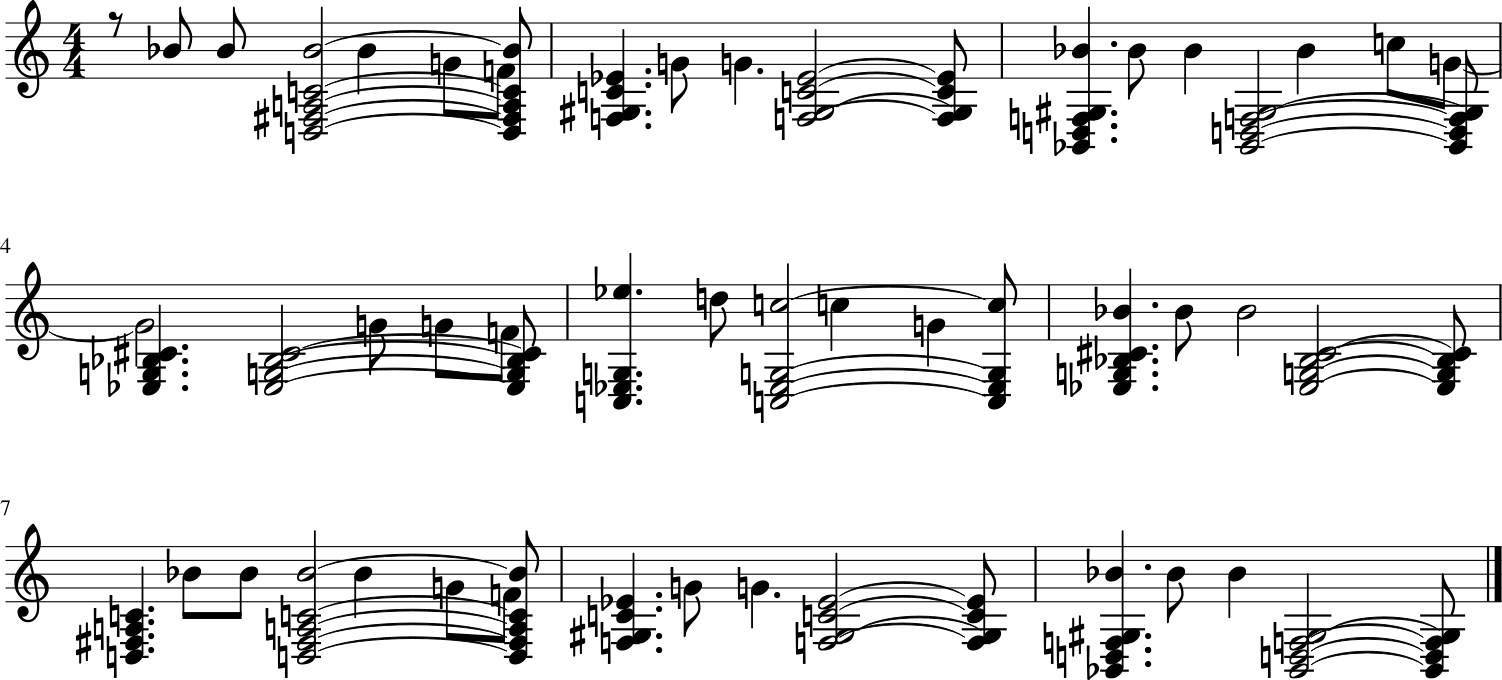

In [169]:
ns.show()

In [170]:
ns = str2stream(pred_out)
ns.show('midi')

In [171]:
str2seq(pred_only)

[[],
 [],
 [B-4t2],
 [],
 [B-4t2],
 [],
 [D3t10, F#3t10, A3t10, C4t10, B-4t2],
 [],
 [B-4t4],
 [],
 [],
 [],
 [G4t2],
 [],
 [F4t2],
 [],
 [F3t6, G#3t6, C4t6, E-4t2, E-4t6],
 [],
 [G4t2],
 [],
 [G4t6],
 [],
 [F3t10, G#3t10, C4t10, E-4t10],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [B-2t6, D3t6, F3t6, G#3t6, B-4t2],
 [],
 [B-4t2],
 [],
 [B-4t4],
 [],
 [B-2t10, D3t10, F3t10, G#3t10],
 [],
 [B-4t4],
 [],
 [],
 [],
 [C5t2],
 [],
 [G4t10],
 [],
 [E-3t6, G3t6, B-3t6, C#4t6],
 [],
 [],
 [],
 [],
 [],
 [E-3t10, G3t10, B-3t10, C#4t10],
 [],
 [],
 [],
 [G4t2],
 [],
 [G4t2],
 [],
 [F4t2],
 [],
 [C3t6, E-3t6, G3t6, E-5t4],
 [],
 [],
 [],
 [D5t2],
 [],
 [C3t10, E-3t10, G3t10, C5t2],
 [],
 [C5t4],
 [],
 [],
 [],
 [G4t4],
 [],
 [],
 [],
 [E-3t6, G3t6, B-3t6, C#4t6, B-4t2],
 [],
 [B-4t2],
 [],
 [B-4t8],
 [],
 [E-3t10, G3t10, B-3t10, C#4t10],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [D3t6, F#3t6, A3t6, C4t6],
 [],
 [B-4t2],
 [],
 [B-4t2],
 [],
 [D3t10, F#3t10, A3t10, C4t10, B-4t2],
 [],
 [B-4t4

### Fastai beam search

In [93]:
pred_out = learn.beam_search(seed, n_words=150, top_k=1, temperature=5); pred_out

'|| t0 nC3 t16 nE3 t16 nG3 t16 || t7 nG3 t4 || t3 nE4 t2 || t1 nD4 t12 || t1 nC3 t16 nD3 t16 nG3 t16 || t11 nD4 t2 || t1 nE4 t2 || t1 nC3 t16 nF3 t16 nA3 t16 nF4 t4 || t3 nE4 t4 || t3 nD4 t4 || t3 nC4 t2 || t1 nD4 t2 || t1 nG2 t8 nC3 t8 nD3 t8 nC4 t8 || t7 nG2 t8 nB2 t8 nD3 t8 nB3 t8 || t7 nC3 t16 nE3 t16 nG3 t16 || t7 nG3 t4 || t3 nE4 t2 || t1 nD4 t12 || t1 nC3 t16 nD3 t16 nG3 t16 || t11 nD4 t2 || t1 nE4 t2 || t1 nC3 t16 nF3 t16 nA3 t16 nF4 t4 || t3 nE4 t4 || t3 nD4 t4 || t3 nC4 t2 || t1 nD4 t2 || t1 nG2 t8 nC3 t8 nD3 t8 nC4 t8 || t7 nG2 t8 nB2 t8 nD3 t8 nB3 t8 || t7 nC3 t16 nE3 t16 nG3 t16 || t7 nG3 t4 || t3 nE4 t2 || t1 nD4 t12 || t1 nC3 t16 nD3 t16 nG3 t16 || t11 nD4 t2 || t1 nE4 t2 || t1 nC3 t16 nF3 t16 nA3 t16 nF4 t4 || t3 nE4 t4 || t3 nD4 t4 || t3 nC4 t2 || t1 nD4 t2 || t1 nG2 t8'

In [94]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'nB3 t8 || t7 nC3 t16 nE3 t16 nG3 t16 || t7 nG3 t4 || t3 nE4 t2 || t1 nD4 t12 || t1 nC3 t16 nD3 t16 nG3 t16 || t11 nD4 t2 || t1 nE4 t2 || t1 nC3 t16 nF3 t16 nA3 t16 nF4 t4 || t3 nE4 t4 || t3 nD4 t4 || t3 nC4 t2 || t1 nD4 t2 || t1 nG2 t8 nC3 t8 nD3 t8 nC4 t8 || t7 nG2 t8 nB2 t8 nD3 t8 nB3 t8 || t7 nC3 t16 nE3 t16 nG3 t16 || t7 nG3 t4 || t3 nE4 t2 || t1 nD4 t12 || t1 nC3 t16 nD3 t16 nG3 t16 || t11 nD4 t2 || t1 nE4 t2 || t1 nC3 t16 nF3 t16 nA3 t16 nF4 t4 || t3 nE4 t4 || t3 nD4 t4 || t3 nC4 t2 || t1 nD4 t2 || t1 nG2 t8'

In [95]:
ns = str2stream(pred_only)
ns.show('midi')

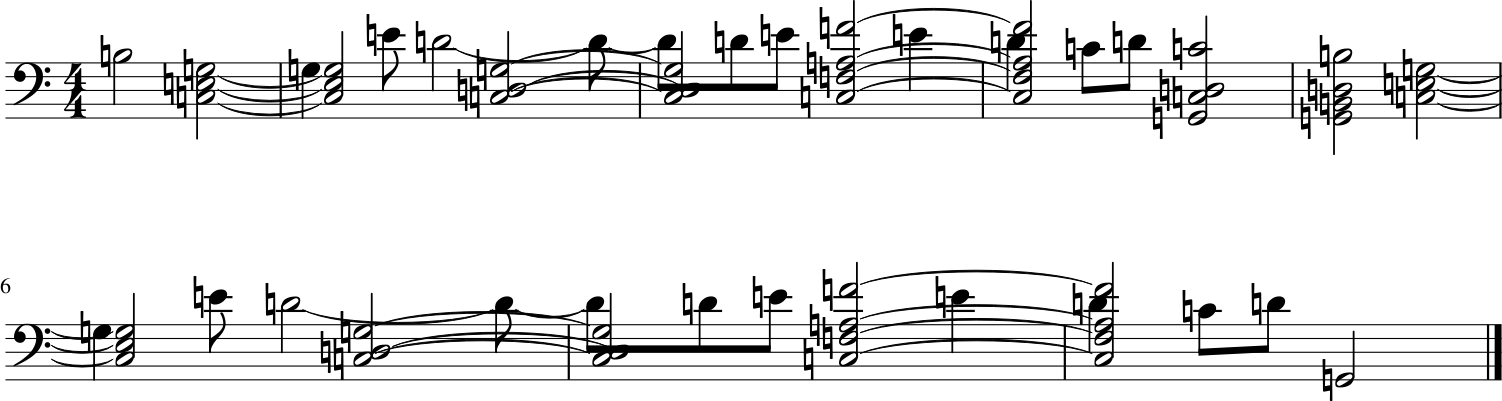

In [96]:
ns.show()

### Beam search

In [97]:
from beam_search import *

In [98]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=1)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

'xxbos  nF3 t8 xxbos || t0 nG#2 t16 nC3 t16 nE-3 t16 nG3 t16 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nB-2 t16 nD3 t16 nF3 t16 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nC3 t16 nE-3 t16 nG3 t16 nC5 t2 || t1 nC5 t2 || t1 nC5 t2 || t1 nC5 t2 || t1 nC5 t2 || t1 nC5 t2 || t1 nC5 t2 || t1 nC5 t2 || t1 nG#2 t16 nC3 t16 nE-3 t16 nG3 t16 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nG4 t2 || t1 nB-2 t16 nD3 t16 nF3 t16 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nB-4 t2 || t1 nC3'

't'


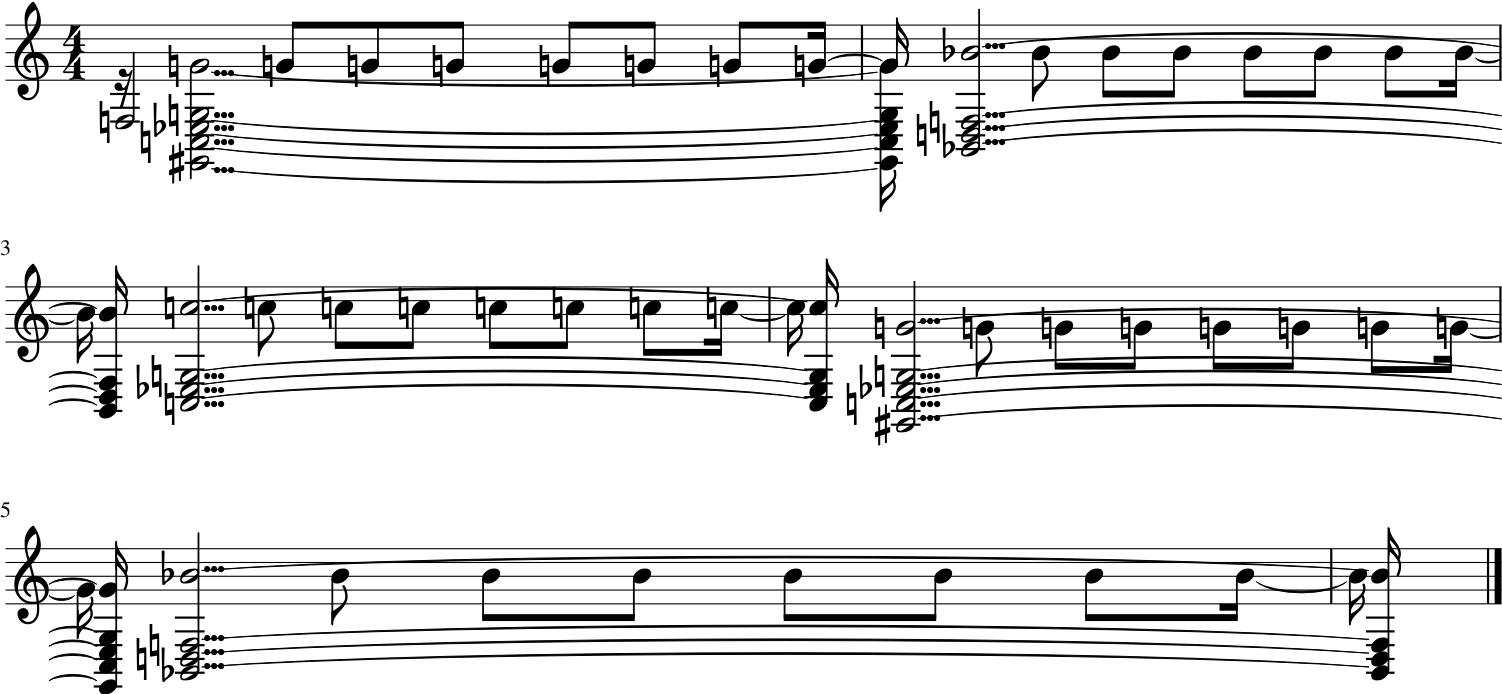

In [99]:
ns_only = str2stream(pred_beam_only).show()

In [100]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

't'


't'


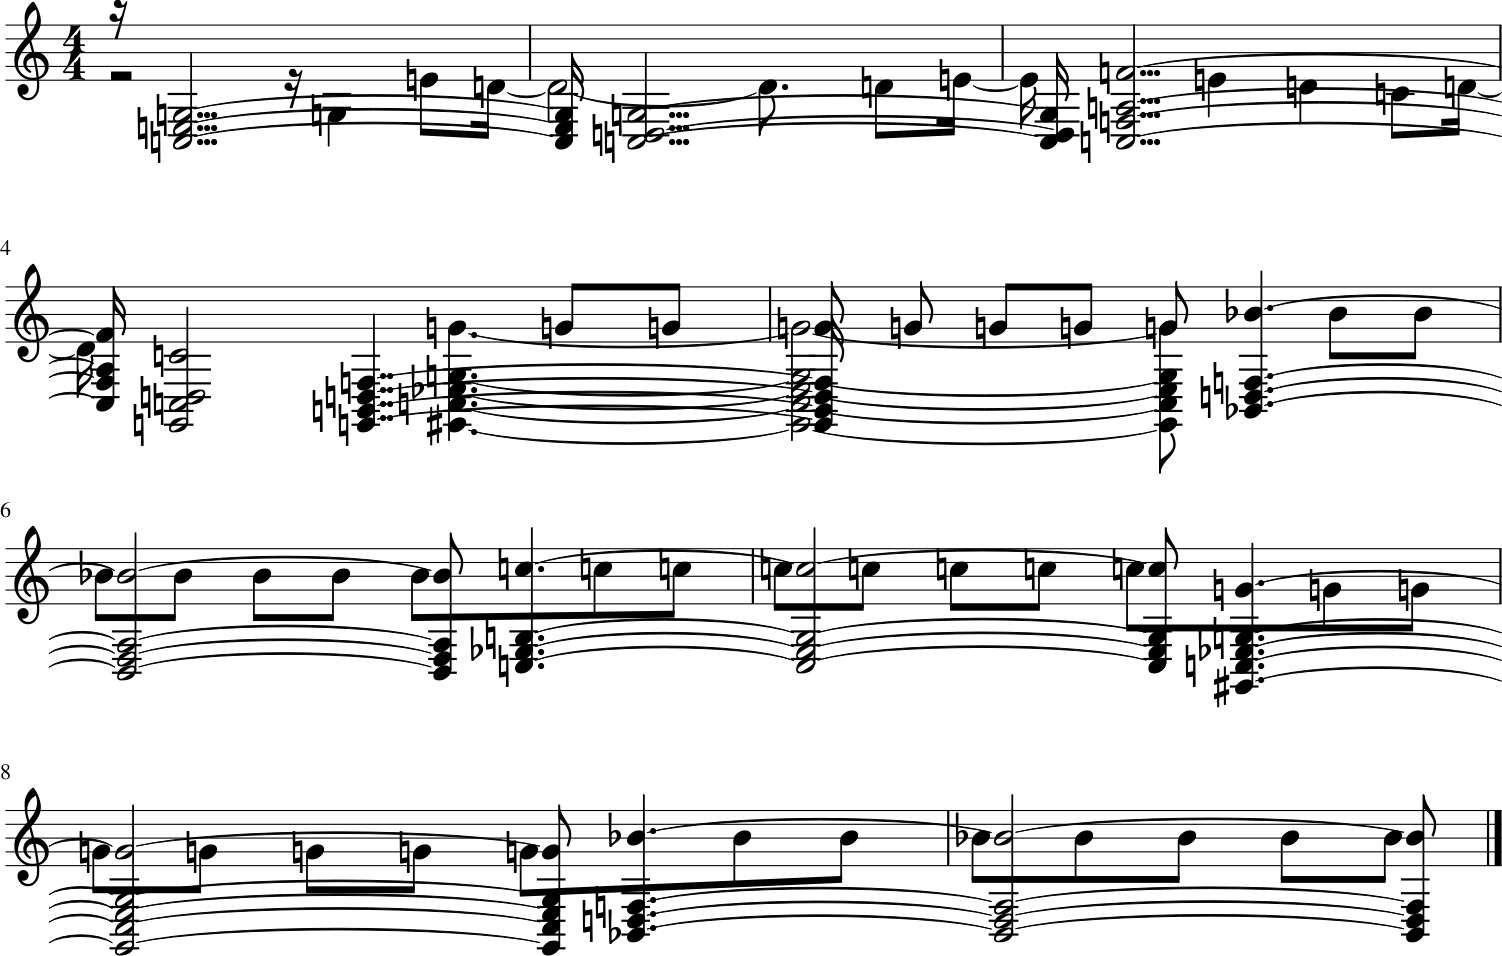

In [101]:
ns = str2stream(pred_beam).show()

In [102]:
ns = str2stream(pred_beam)
ns.show('midi')

't'
